In [1]:
import pandas as pd
from utils import *
from scipy import optimize

In [75]:
trte = []
D = []
b = []
ell = []
corr_r = []
corr_y = []
rmse = []

In [3]:
def g(ell, gp, mean_ntk, data):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})


    gp.fit(data[0], data[1])
    mean = gp.predict(data[2])
    
    return np.sqrt(np.mean((mean_ntk - mean)**2))

Thyroid
0.941**2 * NTK(depth=3, c=2.000, bias=37760.474) + WhiteKernel(noise_level=0.885)
0.941**2 * Matern(length_scale=2.17, nu=0.5) + WhiteKernel(noise_level=0.885)
Seeds


/anaconda/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-04. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.52**2 * NTK(depth=25, c=2.000, bias=0.000) + WhiteKernel(noise_level=0.0001)
0.52**2 * Matern(length_scale=0.29, nu=0.5) + WhiteKernel(noise_level=0.0001)
Yeast
1.17**2 * NTK(depth=10, c=2.000, bias=0.002) + WhiteKernel(noise_level=0.503)
1.17**2 * Matern(length_scale=0.654, nu=0.5) + WhiteKernel(noise_level=0.503)


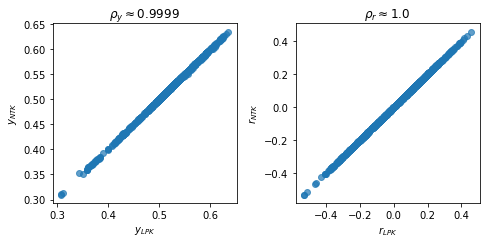

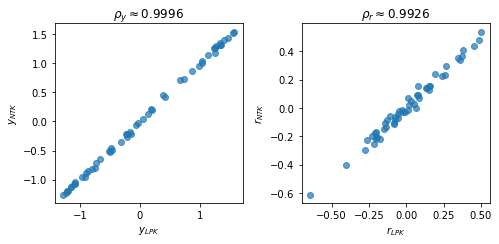

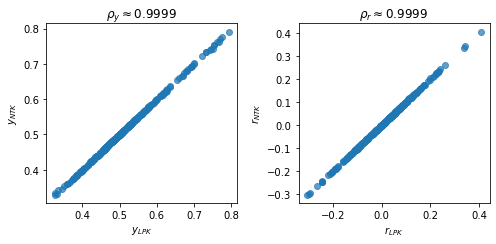

In [90]:
name = ['Thyroid', 'Seeds', 'Yeast']
location = ['./data/thyroid/ann-train.data', './data/seeds/seeds_R.dat', './data/yeast/yeast.data']

trte = []
D = []
b = []
ell = []
corr_r = []
corr_y = []
rmse = []

for x, y in zip(name, location):
    header = 0 if x=='Seeds' else None
    index_col = 0 if x=='Seeds' else None
    data = pd.read_csv(y, header=header, index_col=index_col, delim_whitespace=True)
    if x=='Thyroid':
        lo=1
        up=21
        depth=3
    if x=='Seeds':
        lo=1
        up=7
        depth=25
    if x=='Yeast':
        lo=2
        up=9
        depth=10

    print(x)
    train_x, test_x, train_y, test_y = train_test_split(data.iloc[:,lo:up], data.iloc[:,lo-1])



    train_x = normalize(train_x)
    test_x = normalize(test_x)
    trte.append(f'{len(train_x)/len(test_x)}')

    data = (train_x, train_y, test_x)

    D.append(depth)
    ntk = (
        ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
        NTK(depth=depth, c=2, bias=0.1, 
            bias_bounds=(1e-5, 1e5)) +
        WhiteKernel(
            noise_level=0.15**2, 
            noise_level_bounds=(1e-4, 10))#(0.001, 1))
    )

    gp_ntk = GPR(kernel=ntk, normalize_y=True, alpha=1e-5, n_restarts_optimizer=3, random_state=3480795)
    gp_ntk.fit(train_x, train_y)

    b.append(gp_ntk.kernel_.k1.k2.bias)
    print(gp_ntk.kernel_)

    mean_ntk = gp_ntk.predict(test_x)


    lpk = (
        ConstantKernel(
            constant_value=gp_ntk.kernel_.get_params()['k1__k1__constant_value'],
            constant_value_bounds='fixed'
        ) *
        Matern(
            nu=1/2,
            # anisotropic true -> trying to fit product of laplace kernels with different lengthscales
            length_scale=1,
            length_scale_bounds='fixed'
        ) + 
        WhiteKernel(
            noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'],
            noise_level_bounds='fixed'
        )
    )

    gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

    ell_lpk = optimize.minimize_scalar(g, args=(
        gp_lpk, mean_ntk, data), 
        method='bounded', bounds=[0.0001, 2], options={'maxiter': 10000})
    for i in range(0, 4):
        tmp = optimize.minimize_scalar(g, args=(
            gp_lpk, mean_ntk, data),
            method='bounded', bounds=[0.0001, 10*(10**i)], options={'maxiter': 10000})
        if tmp.fun < ell_lpk.fun:
            ell_lpk = tmp

    try:
        gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
    except:
        gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
    gp_lpk.fit(train_x, train_y)

    ell.append(ell_lpk.x)
    rmse.append(ell_lpk.fun)
    print(gp_lpk.kernel_)

    mean_lpk_opt = gp_lpk.predict(test_x)

    corr_r.append(np.corrcoef((np.array(test_y.iloc[0:1000])-mean_ntk), (np.array(test_y.iloc[0:1000])-mean_lpk_opt))[0,1])
    corr_y.append(np.corrcoef((mean_ntk), (mean_lpk_opt))[0, 1])

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3.5))
    ax[0].scatter(mean_lpk_opt, mean_ntk, alpha=0.7)
    ax[0].set_xlabel(r'$y_{LPK}$')
    ax[0].set_ylabel(r'$y_{NTK}$')
    ax[0].set_title(r'$\rho_y \approx$' + f'{round(corr_y[-1], 4)}')
    ax[1].scatter(np.array(test_y.iloc[0:1000])-mean_lpk_opt, np.array(test_y.iloc[0:1000])-mean_ntk,  alpha=0.7)
    ax[1].set_xlabel(r'$r_{LPK}$')
    ax[1].set_ylabel(r'$r_{NTK}$')
    ax[1].set_title(r'$\rho_r \approx$' + f'{round(corr_r[-1], 4)}')
    # fig.suptitle(np.sqrt(np.mean((np.array(test_y.iloc[0:1000])-mean_ntk)**2)))
    fig.tight_layout()

    fig.savefig(f'./experiments/uci/{name}.svg')

In [91]:
data = {
    'Dataset' : name,
    'Train/Test' : trte,
    r'$\ell$' : ell,
    r'$\rho_r$' : corr_r,
    r'$\rho_y$' : corr_y,
    'RMSE' : rmse
}
print(pd.DataFrame(data).to_latex())

\begin{tabular}{lllrrrr}
\toprule
{} &  Dataset &          Train/Test &    \$\textbackslash ell\$ &  \$\textbackslash rho\_r\$ &  \$\textbackslash rho\_y\$ &      RMSE \\
\midrule
0 &  Thyroid &                 3.0 &  2.170098 &  0.999991 &  0.999909 &  0.000787 \\
1 &    Seeds &  2.9622641509433962 &  0.290075 &  0.992614 &  0.999598 &  0.028137 \\
2 &    Yeast &                 3.0 &  0.653536 &  0.999949 &  0.999931 &  0.001101 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_5036/286614886.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(data).to_latex())


In [67]:
name.append("Yeast")
data = pd.read_csv("./data/yeast/yeast.data", header=None, index_col=None, delim_whitespace=True)
data = data.iloc[:, 1:9]

In [71]:
train_x, test_x, train_y, test_y = train_test_split(data.iloc[:,0:7], data.iloc[:,7])

In [72]:
data = (train_x, train_y, test_x)
trte.append(f'{len(train_x)/len(test_x)}')

In [73]:
train_x_norm = normalize(train_x)

In [74]:
depth = 25
D.append(depth)
ntk = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=depth, c=2, bias=0.1, 
        bias_bounds=(1e-5, 1e5)) +
    WhiteKernel(
        noise_level=0.15**2, 
        noise_level_bounds=(1e-4, 10))#(0.001, 1))
)

gp_ntk = GPR(kernel=ntk, normalize_y=True, alpha=1e-5, n_restarts_optimizer=3, random_state=3480795)
gp_ntk.fit(train_x_norm, train_y)

KeyboardInterrupt: 

In [49]:
b.append(gp_ntk.kernel_.k1.k2.bias)
gp_ntk.kernel_

0.662**2 * NTK(depth=25, c=2.000, bias=0.000) + WhiteKernel(noise_level=0.0001)

In [50]:
mean_ntk = gp_ntk.predict(normalize(test_x))

In [53]:
lpk = (
        ConstantKernel(
            constant_value=gp_ntk.kernel_.get_params()['k1__k1__constant_value'],
            constant_value_bounds='fixed'
        ) *
        Matern(
            nu=1/2,
            # anisotropic true -> trying to fit product of laplace kernels with different lengthscales
            length_scale=1,
            length_scale_bounds='fixed'
        ) + 
        WhiteKernel(
            noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'],
            noise_level_bounds='fixed'
        )
    )

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

ell_lpk = optimize.minimize_scalar(g, args=(
    gp_lpk, mean_ntk, data), 
    method='bounded', bounds=[0.0001, 2], options={'maxiter': 10000})
for i in range(0, 4):
    tmp = optimize.minimize_scalar(g, args=(
        gp_lpk, mean_ntk, data),
        method='bounded', bounds=[0.0001, 10*(10**i)], options={'maxiter': 10000})
    if tmp.fun < ell_lpk.fun:
        ell_lpk = tmp

try:
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
except:
    gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
gp_lpk.fit(train_x_norm, data[1])

ell.append(ell_lpk.x)
rmse.append(ell_lpk.fun)
gp_lpk.kernel_

0.662**2 * Matern(length_scale=0.684, nu=0.5) + WhiteKernel(noise_level=0.0001)

In [56]:
mean_lpk_opt = gp_lpk.predict(normalize(test_x))

/anaconda/envs/thesis/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


In [57]:
corr_r.append(np.corrcoef((np.array(test_y.iloc[0:1000])-mean_ntk), (np.array(test_y.iloc[0:1000])-mean_lpk_opt))[0,1])
corr_r[-1]

7.936200602513772e-01

In [58]:
corr_r.append(np.corrcoef((np.array(test_y.iloc[0:1000])-mean_ntk), (np.array(test_y.iloc[0:1000])-mean_lpk_opt))[0,1])
corr_y.append(np.corrcoef((mean_ntk), (mean_lpk_opt))[0, 1])

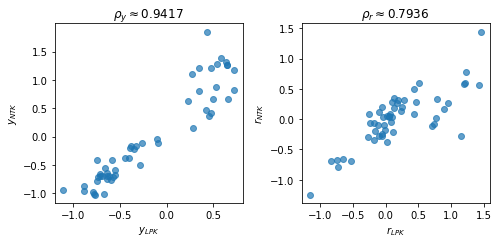

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3.5))
ax[0].scatter(mean_lpk_opt, mean_ntk, alpha=0.7)
ax[0].set_xlabel(r'$y_{LPK}$')
ax[0].set_ylabel(r'$y_{NTK}$')
ax[0].set_title(r'$\rho_y \approx$' + f'{round(np.corrcoef((mean_ntk), (mean_lpk_opt))[0, 1], 4)}')
ax[1].scatter(np.array(test_y.iloc[0:1000])-mean_lpk_opt, np.array(test_y.iloc[0:1000])-mean_ntk,  alpha=0.7)
ax[1].set_xlabel(r'$r_{LPK}$')
ax[1].set_ylabel(r'$r_{NTK}$')
ax[1].set_title(r'$\rho_r \approx$' + f'{round(np.corrcoef((np.array(test_y.iloc[0:1000])-mean_ntk), (np.array(test_y.iloc[0:1000])-mean_lpk_opt))[0,1], 4)}')
# fig.suptitle(np.sqrt(np.mean((np.array(test_y.iloc[0:1000])-mean_ntk)**2)))
fig.tight_layout()

In [65]:
fig.savefig(f'./experiments/uci/{name}.svg')